# Final Project Phase 2 Summary
This Jupyter Notebook (.ipynb) will serve as the skeleton file for your submission for Phase 2 of the Final Project. Complete all sections below as specified in the instructions for the project, covering all necessary details. <b>Make sure that on every segment of code you write, you include an author tag (see below)</b>. We will use this to grade your individual code (Do this whether you are in a group or not). Good luck! <br><br>

Note: To edit a Markdown cell, double-click on its text.

## Jupyter Notebook Quick Tips
Here are some quick formatting tips to get you started with Jupyter Notebooks. This is by no means exhaustive, and there are plenty of articles to highlight other things that can be done. We recommend using HTML syntax for Markdown but there is also Markdown syntax that is more streamlined and might be preferable. 
<a href = "https://towardsdatascience.com/markdown-cells-jupyter-notebook-d3bea8416671">Here's an article</a> that goes into more detail. (Double-click on cell to see syntax)

# Heading 1
## Heading 2
### Heading 3
#### Heading 4
<br>
<b>BoldText</b> or <i>ItalicText</i>
<br> <br>
Math Formulas: $x^2 + y^2 = 1$
<br> <br>
Line Breaks are done using br enclosed in < >.
<br><br>
Hyperlinks are done with: <a> https://www.google.com </a> or 
<a href="http://www.google.com">Google</a><br>

# Data Collection and Cleaning


Transfer/update the data collection and cleaning you created for Phase I below. You may include additional cleaning functions if you have extra datasets. 


## Downloaded Dataset Requirement



In [38]:
import pandas as pd
import re
def data_parser():
    df = pd.read_csv("covid_confirmed_usafacts.csv")
    hasAnyDiscrepancies = []
    discrepancyDates = []
    for index, row in df.iterrows():
        discrepancies = []
        hasDiscrepancies = False
        prevCol = list(row.iteritems())[4]
        for col in list(row.iteritems())[5:]:
            if col[1] - prevCol[1] < -10: 
                # Define a discrepancy to be a day where there are 10 more cumulative cases than the next day
                # This allows some tolerance for slight miscounts from day to day. 
                hasDiscrepancies = True
                discrepancies.append(prevCol[0])
            prevCol = col
        hasAnyDiscrepancies.append(hasDiscrepancies)
        discrepancyDates.append(discrepancies)
    df.loc[:,"Big Discrepancy"] = hasAnyDiscrepancies
    df.loc[:,"Discrepancy Dates"]=discrepancyDates
    #print(list(df.columns))
    months = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August",9:"September",10:"October",11:"November"}
    df["Jan New Cases"]=df.loc[:,"1/31/20"]
    for i in range (2,11):
        lastDayThisMonth = re.findall(",("+str(i)+"/\d{2}/20)",",".join(df.columns))[-1]
        lastDayPrevMonth = re.findall(",("+str(i-1)+"/\d{2}/20)",",".join(df.columns))[-1]
        df[months[i][:3]+" New Cases"]=df.loc[:,lastDayThisMonth]-df.loc[:,lastDayPrevMonth]
        # Above loops makes the new cases per month column. 
        # Uses regex to find the last day of this month and the previous month.
        # Note the df contains cumulative totals on each day. Therefore, we just need to do last day of this month minus prev
    df["YTD Total"]=df.loc[:,lastDayThisMonth]
    pd.concat([df.iloc[:,:4], df.loc[:,"Big Discrepancy":]], axis=1).to_csv("COVIDCasesCountyMonthlySummary.csv", index=False) 




############ Function Call ############
data_parser()

## Web Collection Requirement \#1


In [39]:
import requests
import csv
# import timeit
# from pprint import pprint
def web_parser1():
    '''
    Notes about this function:
    The Federal Reserve API releases county level data for previous month's unemployment rate around the end of current month
    (that is, September unemployment rate is released throughout end of October into early November)
    Therefore, unemployment rates for September may be available for all counties, depending on when this is graded
    At the time of this project's completion, only Washington DC had available data for September uneployment, all other counties did not
    In general, a handful of counties will have information missing.
    The code is set to handle both cases, and to average Q3 unemployment rates appropriately.
    
    
    The code takes some time to run, due to the organization of the output (rows mapping to each county) and the organization
    of the Federal Reserve API response (having to request by month, rather than by county). As such, searching through the 
    data causes the code to be somewhat slow. For me, it took roughly 13 seconds across several trials.
    '''
    key = "19adc513930a610b8f54a46657a55830" # API Key
    months = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August",9:"September"}
    monthlyData = []
    for i in range (1,10): # Unemployment rate is only available up to and including August, as of 10/22/20
        response = requests.get(f"https://api.stlouisfed.org/geofred/series/data?series_id=SCABBE1URN&api_key={key}&date=2020-0{str(i)}-01&file_type=json")
        monthlyData.append(response.json()["meta"]["data"]["2020 "+months[i]])
    with open("UNRATE2020county.csv", "w") as fout:
        writer = csv.writer(fout, lineterminator="\n")
        header = ["FIPS","County", "State", "UNRATE-JAN", "UNRATE-FEB", "UNRATE-MAR", "UNRATE-APR", "UNRATE-MAY","UNRATE-JUN","UNRATE-JUL","UNRATE-AUG","UNRATE-SEP", "UNRATE-Q1","UNRATE-Q2","UNRATE-Q3","Q2-Q1","Q3-Q1","PRESENT-JAN", "DECREASE","BIG-DECREASE"]
        writer.writerow(header)
        for county in monthlyData[0]: # calls data embeded in like 3 dictionaries
            countyList = []
            countyList.append(int(county["code"])) # A FIPS code is a 5 digit code representing each county.
            countyList.append(county["region"][:-4]) # slices the county name (everything before the  comma for the state)
            countyList.append(county["region"][-2:]) # slices the state abbreviation out of each "region"
            countyList.append(float(county["value"])) # accesses the UNRATE for January
            for i in range (2,10): # accesses the UNRATE for the remainder of the months (up to Sept if available, otherwise to Aug)
                        added=False # Used to handle missing data for Sept (most regions do not have Sept data available yet)
                        for entry in monthlyData[i-1]: 
                            if(countyList[0]==int(entry["code"])):
                                countyList.append(float(entry["value"]))
                                added=True
                                break # added for efficiency purposes. 
                        if not added:
                            countyList.append(None)
            # Below appends summary statistics - average UNRATE per qarter, difference from Q1 for each of Q2 and Q3, and difference Aug to Jan
            countyList.append(sum(countyList[3:6])/3)
            countyList.append(sum(countyList[6:9])/3)
            difference = 0
            if None in countyList[9:12]: # Computes Q3 average excluding Sept and computes difference from latest unemp rate to January
                countyList.append(sum(countyList[9:11])/2)
                difference = countyList[10]-countyList[3]
            else:
                countyList.append(sum(countyList[9:12])/3)
                difference = countyList[11]-countyList[3]
            countyList.append(countyList[13]-countyList[12]) # difference between Q2 and Q1, positive indicates higher UNRATE in Q2
            countyList.append(countyList[14]-countyList[12]) # difference between Q3 and Q1, positive indicates higher UNRATE in Q3
            countyList.append(difference) # difference between latest available month (either Aug or Sept) and Jan 2020 UNRATE
            countyList.append(countyList[17]<0)
            countyList.append(countyList[17]<-5)
            writer.writerow(countyList)




############ Function Call ############
web_parser1()
# extime = timeit.timeit(web_parser1, number=1)
# print(extime)

## Web Collection Requirement #2

In [40]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
# import timeit
# from pprint import pprint
def web_parser2():
    wiki = requests.get("https://en.wikipedia.org/wiki/List_of_United_States_counties_and_county_equivalents")
    soup = BeautifulSoup(wiki.text, "html.parser")
    table = soup.find("table", {"class":"wikitable sortable"})
    counties = list(table.find_all("tr"))
    countyList = []
    for county in counties[1:]:
        countyInfo = []
        name = re.findall('\">([A-Za-z (),-–\.\']+)</a>',str(county))[0]
        if county.find_all("span", {"class":"flagicon"}) != []: # this indicates that we've reached a new state/territory
            state = re.findall('title=\"([A-Za-z \.\'\(\)ʻ]*)\"', str(county))[-1] 
            # Special class of characters created because, apparently, Wikipedia formats some state names with () and ʻ
            # index -1 is used to account for special cases in formatting of some terrioties, where find_all actually found multiple matches
            state = re.sub(' \(.+\)', '', state) 
            # accounts for cases where (U.S. State) is added at the end of the name, 
            # which occurs for NY and WA (to differentiate from the cities) and GA (to differentiate from the country)
        population = int(re.findall('right;\">([0-9,]+)', str(county))[0].replace(",",""))
        countyInfo.append(name)
        countyInfo.append(state)
        countyInfo.append(population)
        countyList.append(countyInfo)
    df = pd.DataFrame(countyList)
    us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','American Samoa': 'AS','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Guam': 'GU','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','U.S. Minor Outlying Islands' : 'UM','Utah': 'UT','Vermont': 'VT','U.S. Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}
    ''' 
    us_state_abrev adopted from the dictionary provided by rogerallen on GitHub. 
    No code logic was taken, only the dictionary mapping states to their abbreviations.
    Original available at https://gist.github.com/rogerallen/1583593
    I made modifications to include some more territories.
    '''
    df.columns = ["County", "State", "Population"]
    df = df.replace({"State":us_state_abbrev}) # replaces state names with abbreviations, to match formatting in other files
    df = df.drop(df[(df["State"]=="VI")|(df["State"]=="PR")|(df["State"]=="UM")|(df["State"]=="MP")|(df["State"]=="GU")|(df["State"]=="AS")].index)
    # Removes most territories, because unemployment rates and Covid case rates aren't provided for these territories, so no analysis could be performed for these
    df.to_csv("countyPopulations.csv", index = False)
    
    
    

############ Function Call ############
web_parser2()
# extime = timeit.timeit(web_parser2, number=1)
# print(extime)

#Inconsistency Revisions
 **If you were requested to revise your inconsistency section from Phase I, enter your responses here. Otherwise, ignore this section.**

For each inconsistency (NaN, null, duplicate values, empty strings, etc.) you discover in your datasets, write at least 2 sentences stating the significance, how you identified it, and how you handled it.

1. 

2. 

3. 

4. (if applicable)

5. (if applicable)


## Data Sources

Include sources (as links) to your datasets.

*   Downloaded Dataset Source: https://static.usafacts.org/public/data/covid-19/covid_confirmed_usafacts.csv?_ga=2.22396091.1452819859.1605629149-2060955456.1603315988. As mentioned in Phase I, usafacts.org itself is not a government site, but it has aggregated all the COVID data for the country from individual State Departments of Health. Note also that the data at this link is updated every day at 4pm, so if you use this link to download the data (rather than the static uploaded file), you might get slightly different correlations.
*   Web Collection #1 Source: https://api.stlouisfed.org/geofred/series/data?series_id=SCABBE1URN&api_key=19adc513930a610b8f54a46657a55830&date=2020-08-01&file_type=json (note that this is the API request for the month of August. The code requests for each month from January to September, which you can find by changing the month in the date in the URL)
*   Web Collection #2 Source: https://en.wikipedia.org/wiki/List_of_United_States_counties_and_county_equivalents



Notes for filenames:
* Data read from "covid_confirmed_usafacts.csv" in Phase I
* Data written to "countyPopulations.csv", "COVIDCasesCountyMonthlySummary.csv", and "UNRATE2020county.csv" in Phase I
* Data written to "countyCaseRates.csv" and "merged.xlsx" in Phase II
* Name of presentation file is "CS2316 - Analysis of COVID Case Rates and Unemployment Rates by County.pptx"

# Data Analysis
For the Data Analysis section, you are required to utilize your data to complete the following:

*   Create at least 5 insights
*   Generate at least 3 data visualizations
*   Export aggregated data to at least 2 summary files 

Create a function for each of the following sections mentioned above. Do not forget to fill out the explanation section for each function. 

Make sure your data analysis is not too simple. Performing complex aggregation and using modules not taught in class shows effort, which will increase the chance of receiving full credit. 

# Graphical User Interface (GUI) Implementation
If you decide to create a GUI for Phase II, please create a separate Python file (.py) to build your GUI. You must submit both the completed PhaseII.ipynb and your Python GUI file.

## Insights

In [43]:
import pandas as pd

def insight1():
    '''
    All insight and visualization functions run on the summary files (saves time from having to run each match multiple times).
    It is necessary to run summary1() and summary2() (in that order) before running any of the insight or visualization methods.
    
    This function finds the correlation between a county's cases/100K in a given month and its unemployment rate in a given month.
    All counties and all months are weighted equally and a single correlation coefficient is produced.
    '''
    merged = pd.read_excel("merged.xlsx")
    
    months={1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct"}

    unrates = merged["UNRATE-JAN"]
    caserates = merged["Jan New Cases/100K"]
    for i in range(2,10):
        unrates = pd.concat([unrates, merged["UNRATE-"+months[i].upper()]])
        caserates = pd.concat([caserates, merged[months[i]+" New Cases/100K"]])

    unrates = unrates.reset_index(drop=True)
    caserates = caserates.reset_index(drop = True)

    df = pd.DataFrame({"Unemployment":unrates, "Cases/100K":caserates})
    
    print(df.corr())
    
    
    
    
    
############ Function Call ############
insight1()

              Unemployment  Cases/100K
Unemployment      1.000000    0.051187
Cases/100K        0.051187    1.000000


### Insight 1 Explanation

This function answers the question of whether a correlation exists between a county's COVID case rate per month and its unemployment rate. It calculates the correlation between these two variables, with each county and each month weighted equally - that is, I simply combined all montly unemployment rates into one column and all new monthly cases per 100K into its own column, making sure that each data point was paired correctly. The correlation between these two variables is rather low, with Pearson's r just over 0.05, suggesting a very, <i>very</i> low positive correlation between a county's unemployment rate and COVID case rate in a given month. To an extent, this is expected (though I did not expect it to be this low). A county's unemployment rate and Covid case rates vary greatly based on aspects of the county itself, and while these two variables may play a very small role in each other, there are likely many other variables with greater impact (such as mask wearing and types of jobs in the given county). Potential better measures to use are changes in unemployment from month to month for a given county (rather than the raw unemployment rate), comparing a county's unemployment rate to its rate at the start of the year (prior to the pandemic), and excluding outlier/"discrepancy" values identified in Phase I. These suggested improved measures are explored in the remaining Insights and Visualizations. 

In [44]:
import pandas as pd
import re

def insight2():
    '''
    All insight and visualization functions run on the summary files (saves time from having to run each match multiple times).
    It is necessary to run summary1() and summary2() (in that order) before running any of the insight or visualization methods.
    
    This function is similar to insight1() in that it finds the correlation between a county's cases/100K in a given month and its unemployment rate in a given month.
    However, it excludes counties with outlier changes in unemployment (defined as any county with a decrease in unemployment from Jan 2020 to Sep 2020)
    And it excludes months in which a county was identified to have COVID case rate counting discrepancies (from Phase I)
    Each individual pair of case rate and unemployment rate is weighted equally.
    '''

    merged = pd.read_excel("merged.xlsx")
    monthsDict={1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct"}
    
    merged.drop(merged[merged["DECREASE"]].index, inplace = True) # Removes entire row with discrepancies in unemployment rate
    merged = merged.reset_index(drop = True)
    countyUNRATES = []
    countyCOVIDRates = []    
    for j in range(1, len(merged.index)):
        entry = merged.iloc[j]
        months = re.findall(r'(\d{1,2})\/\d{1,2}\/20',entry.loc["Discrepancy Dates"])
        for i in range(1,10):
            if str(i) not in months:
                countyCOVIDRates.append(entry.loc[monthsDict[i]+" New Cases/100K"])
                countyUNRATES.append(entry.loc["UNRATE-"+monthsDict[i].upper()])
    df = pd.DataFrame({"Unemployment":countyUNRATES, "Cases/100K":countyCOVIDRates})
    print(df.corr())


############ Function Call ############
insight2()

              Unemployment  Cases/100K
Unemployment      1.000000    0.086166
Cases/100K        0.086166    1.000000


### Insight 2 Explanation

This function answers a very similar question to the previous function - whether or not a correlation exists between the COVID cases in a county in a given month and the county's unemployment rate - however, this function excludes all identified discrepancy values from Phase I. This would include excluding the entire county if the county's unemployment rate dropped from Jan 2020 to Sep 2020 (these counties likely have a highly seasonal economy, and thus the pandemic's economic impact was not enough to counteract the normal decrease in unemployment rate) as well as counties that had case number discrepancies (from the daily reported cases in the original government dataset) - for these, only the particular month whose case count was questionable was excluded, rather than the entire county. It was expected that this would produce a higher correlation between the two variables, since this would exclude any major outliers and problematic counts. Indeed, it did produce a higher correlation coefficient at r=0.086, indicating a low, slightly positive correlation between unemployment rates in a given month and new COVID cases per 100K in that month. However, you will note, this is still a very low correlation coefficient. As with insight1(), both methods produced much lower correlation coefficients than I expected. I expected a weak correlation between case rates and unemployment rates, as one would expect a county with many cases to either shut down or have too many people unable to work that produces high unemployment rates. However, the correlation was much weaker than I expected, suggesting once again, that there are many other variables that play roles. I can only speculate as to what these may include, but I suspect that it includes types of employment (ease of switching to remote work, for instance), mask wearing compliance, and access to healthcare, among many other variables.

In [45]:
import pandas as pd

def insight3():
    '''
    All insight and visualization functions run on the summary files (saves time from having to run each match multiple times).
    It is necessary to run summary1() and summary2() (in that order) before running any of the insight or visualization methods.
    
    This function compares the current month's COVID case rates to the next month's unemployment rates for a given county and determines if a correlation exists between the two.
    '''
  # compare current month covid to next month unrate


    merged = pd.read_excel("merged.xlsx")
    months={1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct"}

    
    merged.drop(merged[merged["DECREASE"]].index, inplace = True) # Removes entire row with discrepancies in unemployment rate
    merged = merged.reset_index(drop = True)
    
    
    unrates = merged["UNRATE-FEB"]
    caserates = merged["Jan New Cases/100K"]

    for i in range(2,9): # Adjust the range because we only have UNRATE through Sept, so we can only check cases through Aug
        unrates = pd.concat([unrates, merged["UNRATE-"+months[i+1].upper()]])
        caserates = pd.concat([caserates, merged[months[i]+" New Cases/100K"]])

    unrates = unrates.reset_index(drop=True)
    caserates = caserates.reset_index(drop = True)

    df = pd.DataFrame({"Unemployment Next Month":unrates, "Cases/100K by Month":caserates})
    print(df.corr())


############ Function Call ############
insight3()

                         Unemployment Next Month  Cases/100K by Month
Unemployment Next Month                 1.000000            -0.001156
Cases/100K by Month                    -0.001156             1.000000


### Insight 3 Explanation

Insight 3 seeks to answer the question of whether or not a correlation exists between the new case rates per 100K population for a given county and the county's unemployment rate in the month after the measured COVID case rate. The rationale for wanting to evaluate this relationship is that it is plausible that having a higher case rate in one month would lead to needing to close down, so the economic effects of the increase in cases aren't necessarily felt right away, but possibly in the next month. As with insight2(), counties with outlier unemployment rates (a county whose unemployment rate decreased from January to September 2020) were excluded, however, unlike insight2(), COVID case counting discrepancies were not excluded. There are several reasons for this: because we are comparing across months, it would be harder to define which month to exclude, and based on my experimentation from insight2(), the effect of excluding the problematic COVID case counts were negligible anyway. Only a small handful of entries actually were removed for this, whereas several hundred out of rougly 3000 counties had outlier unemployment rates. At any rate, this produced an even lower correlation coefficient, with r=-0.001156. This surprised me. I expected a higher correlation between the two variables than in either of the previous insights, primarily because unemmployment rate is a lagging indicator, meaning it usually takes time to effectively highly economic events. Such a low correlation (so much so to suggest no correlation whatsoever )suggests that, in addition to many variables being at play (as mentioned in the previous insights), the economic impacts of COVID take place relatively quickly, seeing as the correlation coefficient for comparing unemployment and new COVID cases per 100K population in the same month was much higher than for comparing COVID cases per 100K of one month to unemployment rate of the next month.

In [46]:
import pandas as pd

def insight4():
    '''
    All insight and visualization functions run on the summary files (saves time from having to run each match multiple times).
    It is necessary to run summary1() and summary2() (in that order) before running any of the insight or visualization methods.
    
    This function compares the current month's COVID case rates to the previous month's unemployment rates for a given county and determines if a correlation exists between the two.
    '''
    merged = pd.read_excel("merged.xlsx")
    months={1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct"}
    
    
    merged.drop(merged[merged["DECREASE"]].index, inplace = True) # Removes entire row with discrepancies in unemployment rate
    merged = merged.reset_index(drop = True)
    
    
    unrates = merged["UNRATE-JAN"]
    caserates = merged["Feb New Cases/100K"]

    for i in range(3,11):
        unrates = pd.concat([unrates, merged["UNRATE-"+months[i-1].upper()]])
        caserates = pd.concat([caserates, merged[months[i]+" New Cases/100K"]])

    unrates = unrates.reset_index(drop=True)
    caserates = caserates.reset_index(drop = True)

    df = pd.DataFrame({"Unemployment Previous Month":unrates, "Cases/100K by Month":caserates})
    print(df.corr())



############ Function Call ############
insight4()

                             Unemployment Previous Month  Cases/100K by Month
Unemployment Previous Month                     1.000000             0.031131
Cases/100K by Month                             0.031131             1.000000


### Insight 4 Explanation

For sake of completeness, having checked for correlation between COVID cases in the current month and unemployment rate in the next month, I also did the opposite - checking correlation between COVID cases in the current month and unemployment in the previous month. The rationale behind this test is that states/counties that have stricter shutdowns (and thus induce a higher unemployment rate in one month) would hopefully see lower case rates the next month. However, knowing that this is the United States, few states imposed true lockdowns, and one can only speculate as to the extent to which these were obeyed. As such, I expected Pearson's r to produce a low, negative correlation. Well, I was right about the part with low correlation (as I've come to expect by now), but the correlation was surprisingly positive. With r=0.0311, this positive correlation was stronger than comparing COVID case rates to the unemployment rate of the next month (insight 3). This suggests that a relatively clearer relationship (though again, a weak one to begin with) exists between the unemployment rate in the previous month and the case rate in the current month. Does this suggest that greater unemployment <i>leads to</i> greater COVID cases? This seems unlikely; rather, I suspect that businesses chose to close down in advance of a pandemic (and as the pandemic progressed following their closure, case rates increased), simply suggesting that both case rates and unemployment rates correlated with the progression of the pandemic. One might speculate here that this would mean our current economic actions don't have a significant effect against the pandemic.

In [47]:
import pandas as pd

def insight5():
  # compare current month covid to deviation of current unrate from jan unrate
    '''
    All insight and visualization functions run on the summary files (saves time from having to run each match multiple times).
    It is necessary to run summary1() and summary2() (in that order) before running any of the insight or visualization methods.
    
    This function compares the current month's COVID case rates to the difference from the county's unemployment rate in a given month
    from its unemployment rate in January (considered to still be "normal").
    '''
    merged = pd.read_excel("merged.xlsx")
    
    months={1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct"}

    
    merged.drop(merged[merged["DECREASE"]].index, inplace = True) # Removes entire row with discrepancies in unemployment rate
    merged = merged.reset_index(drop = True)
    
    
    unrates = merged["UNRATE-JAN"]-merged["UNRATE-JAN"]
    caserates = merged["Jan New Cases/100K"]

    for i in range(2,10):
        unrates = pd.concat([unrates, merged["UNRATE-"+months[i].upper()]-merged["UNRATE-JAN"]]) 
        caserates = pd.concat([caserates, merged[months[i]+" New Cases/100K"]])

    unrates = unrates.reset_index(drop=True)
    caserates = caserates.reset_index(drop = True)

    df = pd.DataFrame({"Unemp Dev from Jan":unrates, "Cases/100K":caserates})
    print(df.corr())




############ Function Call ############
insight5()

                    Unemp Dev from Jan  Cases/100K
Unemp Dev from Jan             1.00000     0.08499
Cases/100K                     0.08499     1.00000


### Insight 5 Explanation

This insight again asks a similar question along the general lines of a correlation between unemployment rates and case rates, however, the difference here is that the specific variable used to measure unemployment rate is the difference (or deviation) of each month's unemployment from January (which I consider to be "normal" unemployment for each county). In doing this, the measure for unemployment is essentially "deviation from normal" rather than the raw value for unemployment, which theoretically removes the normal variation of unemployment rates from county to county. In this case, I would expect a stronger, positive correlation between the variables (again, I am excluding counties with the identified discrepancy/outlier unemployment rate but not case rates, as was followed in Insights 3 and 4). Indeed, this does result in a higher correlation, though it is still pretty low. At r=0.085, there is a rather low (though higher than in all the other insight methods), positive correlation between difference in unemployment from the start of the year per month and COVID case rates per month. This most likely the most effective correlation variable to use for unemployment (excluding those with seasonal economies) as it measures a change from normal - in this method, for the months of January and February, most US counties will have no change in unemployment rate from normal and no COVID cases, allowing for a nearly perfect correlation in these months. Yet the fact that the correlation coefficient is still so low suggests, as with all the previous insights, that many other variables are involved in both COVID case rates as well as the unemployment rate. If any positive has come from this, it's that this lack of correlation suggests that COVID mitigation doesn't come down to a complete economic disaster (that is, more of one than it already is) - there are many other potential actions/variables (that go beyond the scope of this project) that could be used to curb the spread of COVID.

## Data Visualizations

                                       Unemployment Change From Month Before  \
Unemployment Change From Month Before                               1.000000   
Cases/100K                                                         -0.145704   

                                       Cases/100K  
Unemployment Change From Month Before   -0.145704  
Cases/100K                               1.000000  


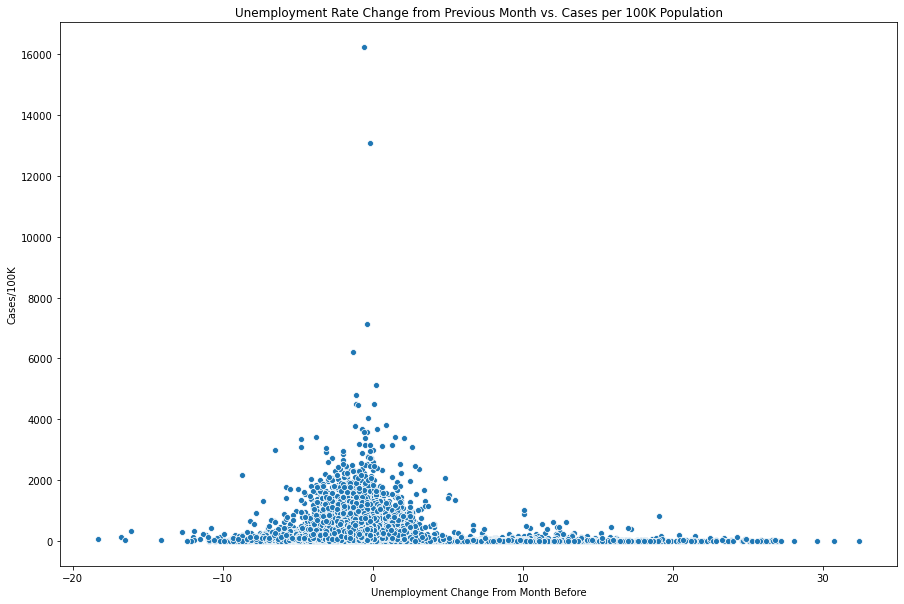

In [53]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def visual1():
    '''
    All insight and visualization functions run on the summary files (saves time from having to run each match multiple times).
    It is necessary to run summary1() and summary2() (in that order) before running any of the insight or visualization methods.
    
    This visualization displays changes in unemployment rate (month to month) against new COVID cases per 100K population by month.
    '''
    merged = pd.read_excel("merged.xlsx")
    
    months={1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct"}

    
    merged.drop(merged[merged["DECREASE"]].index, inplace = True) # Removes entire row with discrepancies in unemployment rate
    merged = merged.reset_index(drop = True)
    
    
    unrates = merged["UNRATE-FEB"]-merged["UNRATE-JAN"]
    caserates = merged["Mar New Cases/100K"]

    for i in range(3,10):
        unrates = pd.concat([unrates, merged["UNRATE-"+months[i].upper()]-merged["UNRATE-"+months[i-1].upper()]])
        caserates = pd.concat([caserates, merged[months[i-1]+" New Cases/100K"]])

    unrates = unrates.reset_index(drop=True)
    caserates = caserates.reset_index(drop = True)

    df2 = pd.DataFrame({"Unemployment Change From Month Before":unrates, "Cases/100K":caserates})
    print(df2.corr())
    plt.figure(figsize=(15,10))
    plt.title("Unemployment Rate Change from Previous Month vs. Cases per 100K Population")
    sns.scatterplot(data=df2, x="Unemployment Change From Month Before", y="Cases/100K")







############ Function Call ############
visual1()

### Visualization 1 Explanation

Visualization 1 follows along the same theme of correlations between unemployment rate and case rates by county, but it chooses a different measure of unemployment. Here, unemployment is measured as the change from the previous month. This would therefore find the correlation between changes in unemployment and new cases by COVID for a given month. Because we are plotting on a graph, I chose a random sample of 500 points to plot (as opposed to plotting perhaps 20,000 points, as it simply clutters the graph up even more than it already appears). Notably, a negative correlation exists here, with r falling somewhere in the -0.1 to -0.2 range (if you want to get new correlations from new samples, just run the function a few times). According to these results, there is a weak negative correlation (but stronger than in all previous insights) between the variables of change in unemployment rate and new cases per 100K - that is, an increase in unemployment rate results in a decrease in the number of cases per 100K. This is seemingly contradictory with insight 4, which suggested that higher unemployment rates were positively correlated (albeit weakly) with higher COVID case rates, but this visualization points out <i>changes</i> in unemployment rate, rather than the raw unemployment rate. This is probably a more useful metric because we are now comparing changes to changes (the COVID case rates were always measured as new cases per month). Furthermore, the correlation is much stronger here. Though it is possibly because random sampling is more likely to exclude severe outliers, I think this is a little more conclusive than the previous insights. The graph only serves to aid in the visualization, that the correlation is weak but one can make out a slight negative pattern out of it. In summary, an increase in unemployment (likely due to economies shutting down) from month to month is also correlated with a decrease in COVID rates (possibly due to less potential for spread), though this correlation is on the weak side. 

                              Unemployment Change from Jan  Cases/100K
Unemployment Change from Jan                      1.000000    0.091105
Cases/100K                                        0.091105    1.000000


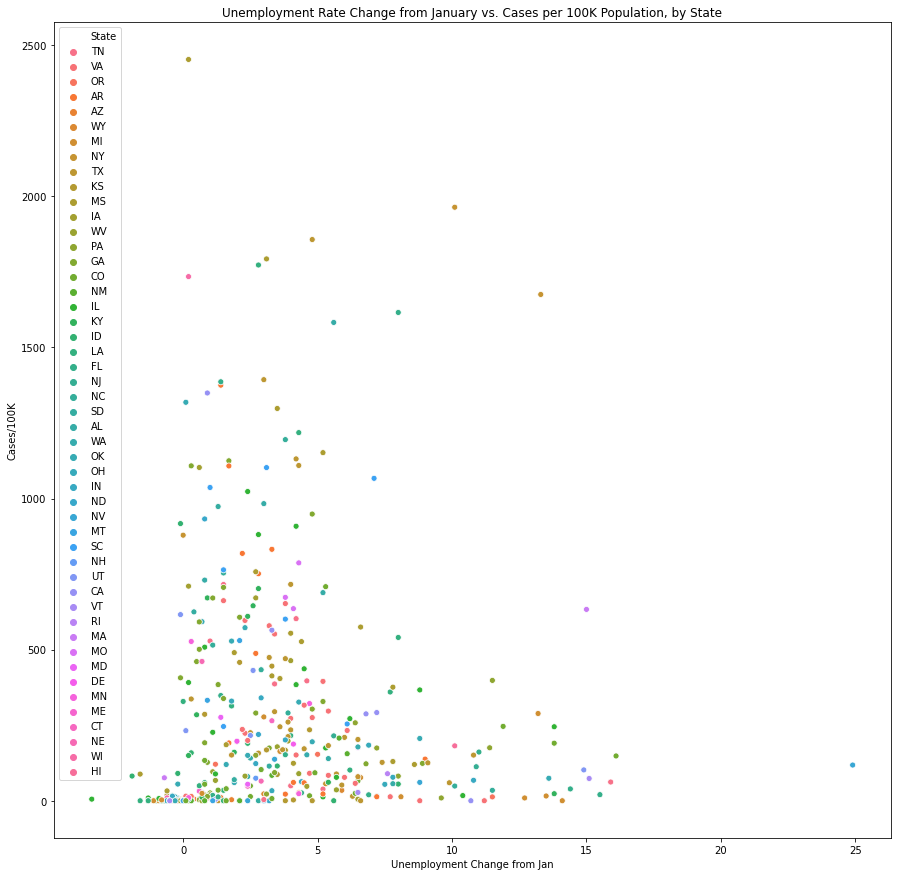

In [56]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


def visual2():
    '''
    All insight and visualization functions run on the summary files (saves time from having to run each match multiple times).
    It is necessary to run summary1() and summary2() (in that order) before running any of the insight or visualization methods.
    
    This function uses the same correlation variables as Insight 5 but modifies it to provide more information and better visualization.
    '''
    merged = pd.read_excel("merged.xlsx")
    
    months={1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct"}

    
    merged.drop(merged[merged["DECREASE"]].index, inplace = True) # Removes entire row with discrepancies in unemployment rate
    merged = merged.reset_index(drop = True)
    
    
    unrates = merged["UNRATE-JAN"]-merged["UNRATE-JAN"]
    caserates = merged["Jan New Cases/100K"]
    states = merged["State"]

    for i in range(2,10):
        unrates = pd.concat([unrates, merged["UNRATE-"+months[i].upper()] -merged["UNRATE-JAN"]]) 
        caserates = pd.concat([caserates, merged[months[i]+" New Cases/100K"]])
        states = pd.concat([states, merged["State"]])
        
    unrates = unrates.reset_index(drop=True)
    caserates = caserates.reset_index(drop = True)
    states = states.reset_index(drop = True)

    df = pd.DataFrame({"Unemployment Change from Jan":unrates, "Cases/100K":caserates, "State":states})
    df2=df.sample(n=500)
    print(df2.corr())
    plt.figure(figsize=(15,15))
    plt.title("Unemployment Rate Change from January vs. Cases per 100K Population, by State")
    sns.scatterplot(data=df2, x="Unemployment Change from Jan", y="Cases/100K", hue="State")





############ Function Call ############
visual2()

### Visualization 2 Explanation

This visualization uses the same method for measuring unemployment as Insight 5 (changes from the unemployment rate in January), removing outliers, and graphs against the new COVID Cases/100K in a given month. As with Visualization 1, a random sample of 500 data points is taken, in an effort to not make the graph too cluttered. Since this is measuring unemployment functionally the same way as Insight 5, the correlation coefficient is expected to be near that of Insight 5, and it is (if you get a sample that's particularly off, just run it a few times and you'll see it should be around r=0.08). However, the visualization adds information that wasn't particularly visible from the insights alone - the spread of each of the variables. For both Cases/100K and Unemployment Change From January, it is clear that there is a right skew for both variables, with most clustered in the lower numbers and a handful of extreme value changes. Because there was no clear cut distinction among the remaining values for outliers (rather, it appears to be a continuous skew, based on the graph), I did not want to exclude any more data points, but this does go to illustrate a problem that I've had throughout the project - the low correlation. It's very reasonable to guess that one potential cause for this is the great variation among both unemployment rates and cases/100K, causing correlation to be off as both variables display extreme high values (and the high values aren't necessarily correlated with each other). In this graph, I attempted to determine if there were perhaps state patterns (as most lockdowns/restrictions are implemented on the state level), but there doesn't seem to be too much of a discernible pattern here either. While this graph does not provide any additional information from Insight 5 as to the size of the correlation between unemployment changes and COVID case rates, it does highlight the issue that the variables have such a great spread.

                       Unemp Change from Jan  Cases/100K  Population
Unemp Change from Jan               1.000000    0.073259    0.161331
Cases/100K                          0.073259    1.000000    0.086796
Population                          0.161331    0.086796    1.000000


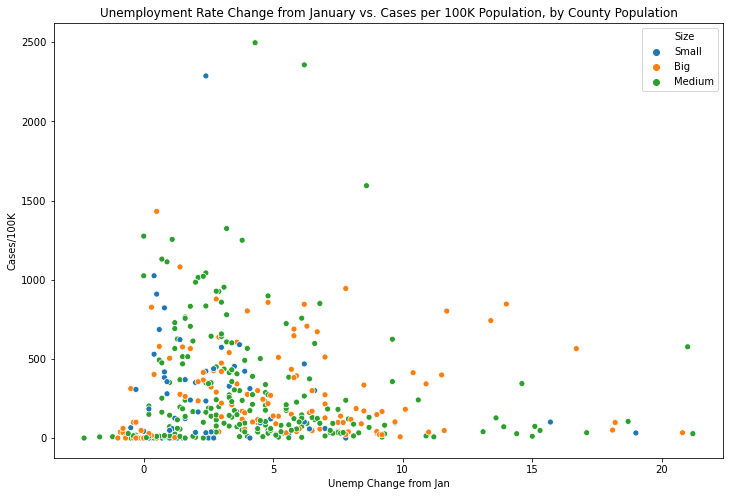

In [57]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def visual3():
    '''
    All insight and visualization functions run on the summary files (saves time from having to run each match multiple times).
    It is necessary to run summary1() and summary2() (in that order) before running any of the insight or visualization methods.
    
    This function uses the same correlation variables as Insight 5 but modifies it to provide more information and better visualization.
    '''
    merged = pd.read_excel("merged.xlsx")
    
    months={1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct"}

    
    merged.drop(merged[merged["DECREASE"]].index, inplace = True) # Removes entire row with discrepancies in unemployment rate
    merged = merged.reset_index(drop = True)
    
    
    unrates = merged["UNRATE-JAN"]-merged["UNRATE-JAN"]
    caserates = merged["Jan New Cases/100K"]
    pops=merged["Population"]

    for i in range(2,10):
        unrates = pd.concat([unrates, merged["UNRATE-"+months[i].upper()] -merged["UNRATE-JAN"]]) 
        caserates = pd.concat([caserates, merged[months[i]+" New Cases/100K"]])
        pops = pd.concat([pops, merged["Population"]])

        
    unrates = unrates.reset_index(drop=True)
    caserates = caserates.reset_index(drop = True)
    pops = pops.reset_index(drop=True)

    df = pd.DataFrame({"Unemp Change from Jan":unrates, "Cases/100K":caserates, "Population":pops})
    df["Size"] = np.where(df["Population"]>=100000, "Big",np.where(df["Population"]>=10000, "Medium", "Small"))
    df2=df.sample(n=500)
    print(df2.corr())
    plt.figure(figsize=(12,8))
    plt.title("Unemployment Rate Change from January vs. Cases per 100K Population, by County Population")
    sns.scatterplot(data=df2, x="Unemp Change from Jan", y="Cases/100K", hue="Size")
    # hist = df.hist(bins=50)




############ Function Call ############
visual3()

### Visualization 3 Explanation

Visualization 3 is quite similar to Visualization 2 in terms of the graphed variables, but instead of coloring points by states, it colors points by population size. Additionally, this allows the correlation between these variables and population to be displayed. As with Visualization 2, counties with outlying unemployment rates (as defined in Phase I of the project) were exlucded, unemployment was measured as a change from January, and a random sample of 500 values was used. The difference here is that counties were grouped into 3 groups: Small (population less than 10,000), Medium (population of at least 10,000 but less than 100,000), and Big (population of at least 100,000). Correlations between unemployment and cases/100K are roughly the same as with Visualization 2 and Insight 5 (as they should be, since I am using the same method of measurement). However, it is evident (more so in the displayed correlation than in the graph) that there is correlation between unemployment rate changes and population - again, this is still a week correlation, but it is stil consistently stronger than the correlation between unemployment rates and COVID cases, suggesting that a county's population could be a confounding variable. As I have mentioned in just about every single prior visualization and insight, the weak correlation between COVID case rates and unemployment rates suggests that many other variables are at play - this visualization suggests that county size (population size) may be one such variable. Alas, this was not the primary scope of this project, but it does partially answer the question - in what way are COVID cases and unemployment rates correlated? As we've seen throughout this project, many more variables likely tie the two together. 

## Summary Files

In [41]:
import re
import csv

def summary1():
    '''
    Summary files are necessary in order to run the Insights and Visualizations. 
    To run the summary files, it is necessary to run each of the data collection (Phase I) functions first.
    Please run summary1() and then summary2() before running any of the insight or visualization functions.
    
    summary1() first matches the county names scraped from Wikipedia (the countyPopulations.csv file) to the counties 
    in the Covid cases file (COVIDCasesCountyMonthlySummary.csv). This is performed using Regex. There are some exceptions
    that could not be matched, so these are hardcoded in. This summary method also removes unallocated state cases and
    handles special cases (some counties were combined and some cases were allocated to a cruise ship). Once this is done
    all county cases are converted to case rates per 100,000 population and these numbers are outputted to a csv summary file.
    '''
    with open("countyPopulations.csv") as fin1:
        pops = list(csv.reader(fin1, delimiter = ","))

    with open("COVIDCasesCountyMonthlySummary.csv") as fin2:
        covid = list(csv.reader(fin2, delimiter=","))

    outputList = [["countyFIPS", "County Name", "State", "stateFIPS", "Big Discrepancy", "Discrepancy Dates", "Jan New Cases/100K", "Feb New Cases/100K", "Mar New Cases/100K", "Apr New Cases/100K", "May New Cases/100K", "Jun New Cases/100K", "Jul New Cases/100K", "Aug New Cases/100K","Sep New Cases/100K","Oct New Cases/100K", "YTD Total/100K", "Population"]]

    for county in covid[1:]:
        newCounty = [element for element in county[:6]]
        found = False
        for counties in pops:
            if county[1] == counties[0]+" County" and counties[1]==county[2]:
                found=True
                for entry in county[6:]:
                    entry = int(entry)/int(counties[2])*100000
                    newCounty.append(entry)
                newCounty.append(counties[2])
                break

        if not found and "Unallocated" not in county[1]: # There are no counties named Statewide Unallocated, so we're just gonna go ahead and ignore those
            # Additional linking methods are attempted. First, I try to remove the words "County" and "of".
            # If issues still could not be resolved, I hardcoded the counties to be linked together. Comments made regarding issue.
            name = county[1]
            name = re.findall(r"(.+) County", name)[0] if re.findall(r"(.+) County", name)!=[] else name
            name = re.findall(r".+ of (.+)", name)[0] if re.findall(r".+ of (.+)", name)!=[] else name
            name = "Mathews" if name=="Matthews" else name # Seems Wikipedia and CDC disagree on the correct number of t's
            name = "DoÃ±a Ana" if name =="Dona Ana" else name # n with tilde formatted poorly when scraped from Wikipedia
            name = "District of Columbia" if name=="Washington" else name # inconsistencies in how we refer to the district
            name = "Kusilvak" if name=="Wade Hampton Census Area" else name # They renamed the county in 2015
            name = "Petersburg" if name=="Petersburg Census Area" else name # named a borough in the other file
            # Now we go searching again...
            for counties in pops:
                if re.sub("[^A-Za-z]+", "", name.lower()) in re.sub("[^A-Za-z]+", "", counties[0].lower()) and counties[1]==county[2]:
                    # print("Found Match: "+county[1]+" matches "+counties[0])
                    found=True
                    for entry in county[6:]:
                        entry = int(entry)/int(counties[2])*100000
                        newCounty.append(entry)
                    newCounty.append(counties[2])
                    break
            # Two remaining cases to handle:
            if name == "Valdez-Cordova Census Area":
                population = int(pops[73][2])+int(pops[74][2]) # In 2019, they split the old Census Area into two new Census Areas
                # print("Population of Valdez-Cordova Census Area: "+str(population))
                found=True
                for entry in county[6:]:
                    entry = int(entry)/population*100000
                    newCounty.append(entry)
                newCounty.append(population)
        if found:
            # The remaining case with no match is the Grand Princess Cruise Ship
            # That would be because a cruise ship is not a US county, so I just didn't include it in the new file
            outputList.append(newCounty)

    with open("countyCaseRates.csv", "w") as fout:
        writer = csv.writer(fout, lineterminator="\n")
        writer.writerows(outputList)





############ Function Call ############
summary1()

In [42]:
import pandas as pd

def summary2():
    '''
    Summary files are necessary in order to run the Insights and Visualizations. 
    Please run summary1() and then summary2() before running any of the insight or visualization functions.
    To run the summary files, it is necessary to run each of the data collection (Phase I) functions first.
    Please run summary1() before running summary2(), as summary2() relies on the output file of summary1().
    
    summary2() takes the countyCaseRates.csv file from summary1() and matches counties there to counties from the
    unemployment csv file from Phase I. These are each loaded into their own DataFrames, which are then matched on FIPS codes.
    A small handful of counties have no match (due to some recent splitting/joining of counties). These counties are dropped.
    Columns containing duplicate information (present in both files) are removed. 
    Finally, this DataFrame is written to a summary Excel file titled "merged.xlsx"
    '''
    caseRates = pd.read_csv("countyCaseRates.csv")
    UNRATES = pd.read_csv("UNRATE2020county.csv")
    merged = caseRates.merge(UNRATES, left_on = "countyFIPS", right_on="FIPS") # Basically an inner join if this were SQL
    merged.drop(["FIPS", "County", "State_y"], axis=1, inplace = True)
    merged.rename(columns={"State_x":"State"}, inplace = True)
    merged.to_excel("merged.xlsx", index = False)





############ Function Call ############
summary2()

# Cited Sources

If you used any additional sources to complete your Data Analysis section, list them here:


*   Example Module Documentation: Pandas Documentation was used for methods we did not cover in class: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html and https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html and https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html. Seaborn Documentation for plotting: https://seaborn.pydata.org/generated/seaborn.scatterplot.html
* Geeks for Geeks: https://www.geeksforgeeks.org/how-to-drop-rows-in-dataframe-by-conditions-on-column-values/ and https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/
* Medium: https://medium.com/@vladbezden/how-to-set-seaborn-plot-size-in-jupyter-notebook-63ffb1415431
*   Example Stack Overflow Assistance



# Video Presentation

If you uploaded your Video Presentation to Bluejeans, YouTube, or any other streaming services, please provide the link here:


*   https://bluejeans.com/s/U1Sg2r9j5kD/


Make sure the video sharing permissions are accessible for anyone with the provided link.